In [49]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This dataset mostly looks at company descriptions, funding amounts, number of investors, and different employee statistics. I'll be using some classic visualization techniques on the numerical data in order to gain some insight into the correlation of numerical featuers, as well as a classic word map for the text features.

In [50]:
file = "/content/drive/MyDrive/GetHimToGoogleInSixMonths/failed_startup_cleaned.csv"
df = pd.read_csv(file, sep=',')
df.head()

,Company Description,Category,Outcome,Cause,Total Funding Amount,Number of Investors,Min Employees,Max Employees,Average Employees
0,Anonymous location-based social network,Social Media,Shut Down,Legal Challenges,73500000,11,10,50,30
1,Platform to share short looping video clips,Social Media,Shut Down,Multiple Reasons,-999,2,50,100,75
2,Platform for mobile interaction design,Design,Shut Down,Acquisition Flu,3800000,1,10,50,30
3,Short-form streaming platform,Entertainment,Shut Down,Multiple Reasons,1800000000,14,250,500,375
4,Finance and accounting software for SMEs,Finances,Shut Down,Poor Product,103000000,17,100,250,175


Below is a quick analysis of the top reasons companies failed.

In [51]:
category_dict = {}
for text in df["Category"]:
  if text in category_dict:
    category_dict[text] += 1
  else:
    category_dict[text] = 1

outcome_dict = {}
for text in df["Outcome"]:
  if text in outcome_dict:
    outcome_dict[text] += 1
  else:
    outcome_dict[text] = 1

cause_dict = {}
for text in df["Cause"]:
  if text in cause_dict:
    cause_dict[text] += 1
  else:
    cause_dict[text] = 1

import heapq

def getKLargest(dictionary, K):
  heap = []
  heapq.heapify(heap)
  for key, value in dictionary.items():
    heapq.heappush(heap, [value, key])
    if len(heap) > K:
      heapq.heappop(heap)
  res = []
  while heap:
    res.append(heapq.heappop(heap))
  return res

outcome_res = []
category_res = []
cause_res = []
outcome_res = getKLargest(outcome_dict, 3)
category_res = getKLargest(category_dict, 3)
cause_res = getKLargest(cause_dict, 3)

print("Top 3 Outcomes: ", outcome_res)
print("Top 3 Categories For Failure: ", category_res)
print("Top 3 Causes For Failure: ", cause_res)

Top 3 Outcomes:  [[4, 'Bankruptcy'], [19, 'Acquired'], [60, 'Shut Down']]
Top 3 Categories For Failure:  [[9, 'Food & Beverage'], [9, 'Transportation'], [11, 'Software & Hardware']]
Top 3 Causes For Failure:  [[12, 'Multiple Reasons'], [13, 'Competition'], [15, 'Bad Business Model']]


In [52]:
df.describe()

,Total Funding Amount,Number of Investors,Min Employees,Max Employees,Average Employees
count,8.400000e+01,84.000000,84.000000,84.000000,84.000000
mean,9.004145e+07,-14.345238,355.880952,611.190476,483.452381
std,3.117062e+08,154.935548,1612.029735,2513.093138,2059.932736
min,-9.990000e+02,-999.000000,1.000000,10.000000,5.000000
25%,2.225000e+06,3.000000,10.000000,50.000000,30.000000
50%,1.120000e+07,7.500000,10.000000,50.000000,30.000000
75%,4.272500e+07,13.250000,50.000000,100.000000,75.000000
max,1.800000e+09,39.000000,10000.000000,15000.000000,12500.000000


Let's start by grabbing the numerical features and then visualizing them (this is where I think a lot of the interesting data lies).

In [53]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
numerical_features

['Total Funding Amount',
 'Number of Investors',
 'Min Employees',
 'Max Employees',
 'Average Employees']

Now let's do some visualization. First we'll start with a histogram, then a heatmap, and we'll move on to cleaning up outliers in the data.


,Total Funding Amount,Number of Investors,Min Employees,Max Employees,Average Employees
Total Funding Amount,1.000000,0.053838,-0.010710,-0.008253,-0.009214
Number of Investors,0.053838,1.000000,0.030051,0.032298,0.031474
Min Employees,-0.010710,0.030051,1.000000,0.994610,0.997997
Max Employees,-0.008253,0.032298,0.994610,1.000000,0.999177
Average Employees,-0.009214,0.031474,0.997997,0.999177,1.000000


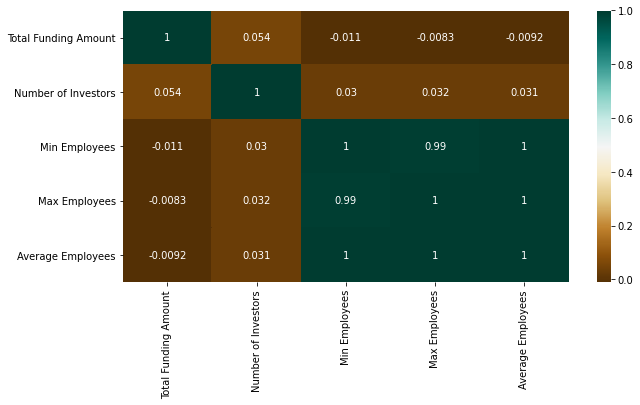

In [54]:
plt.figure(figsize=(10,5))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

Interesting! It seems that there is a greater than 50% correlation between number of investors and the total funding amount, which intuitively makes sense, however I'm skeptical that this is influenced by the large outliers in the dataset.

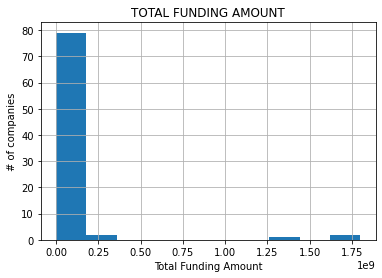

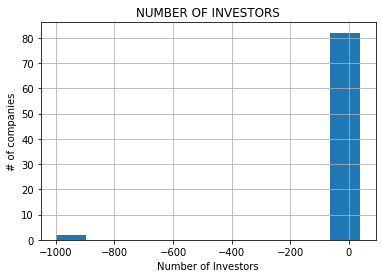

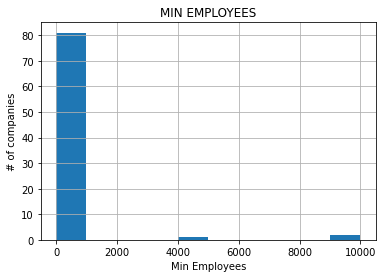

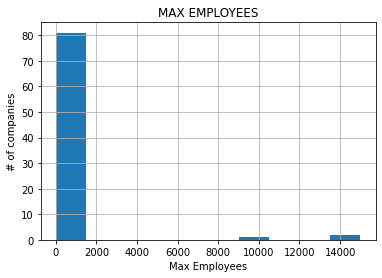

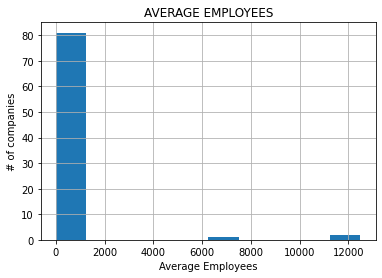

In [55]:
for feature in numerical_features:
  data = df.copy()
  data[feature].hist()
  plt.title(feature.upper())
  plt.xlabel(feature)
  plt.ylabel("# of companies")
  plt.show()

Hmmm, looks like there a lot of really extreme outliers. Let's get a better sense of what most company's that failed looked like.

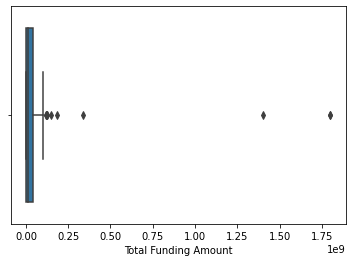

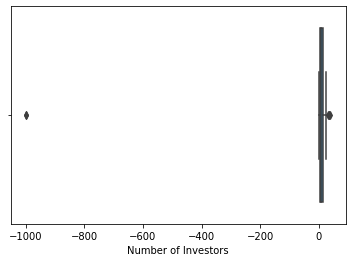

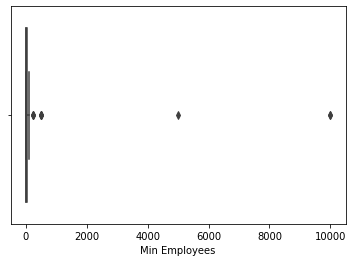

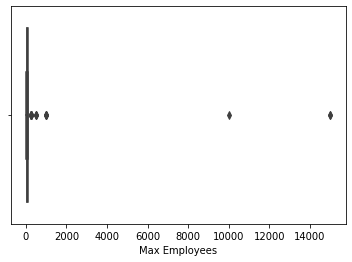

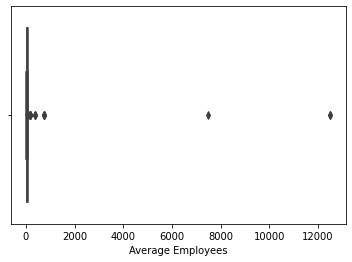

In [56]:
for feature in numerical_features:
  data = df.copy()
  sns.boxplot(x = data[feature])
  plt.xlabel(feature)
  plt.show()

Ahh, now we understand just how extreme these outliers are. Let's use the IQR score technique to remove these outliers and clean out our data just a bit more.

In [57]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Total Funding Amount    40500000.00
Number of Investors           10.25
Min Employees                 40.00
Max Employees                 50.00
Average Employees             45.00
dtype: float64


In [58]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

(58, 9)

Let's see if that helped:

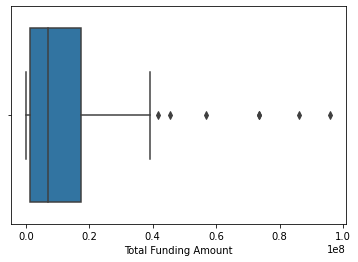

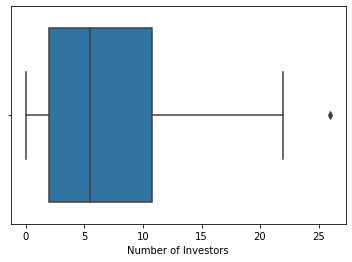

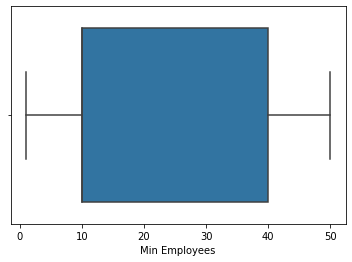

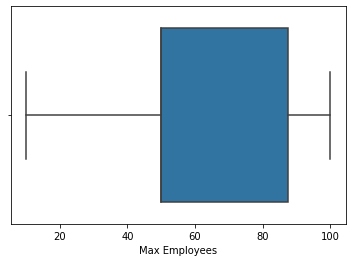

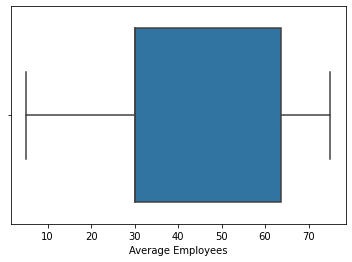

In [59]:
for feature in numerical_features:
  data = df.copy()
  sns.boxplot(x = data[feature])
  plt.xlabel(feature)
  plt.show()

Great! Much better, now let's look at the initial plots once again.

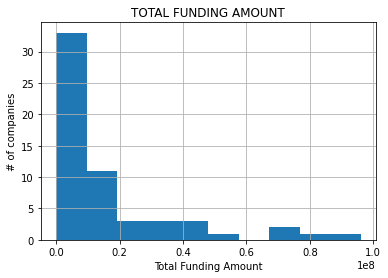

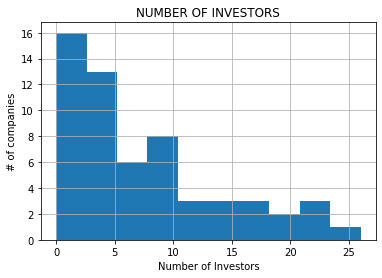

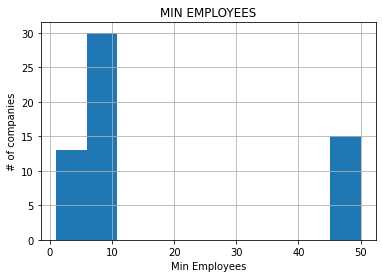

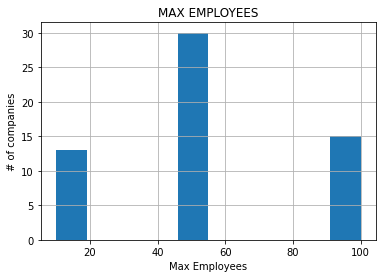

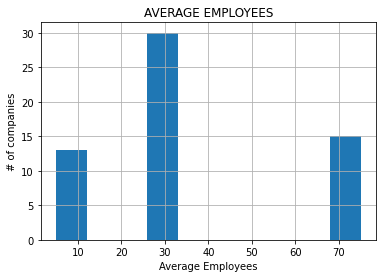

In [60]:
for feature in numerical_features:
  data = df.copy()
  data[feature].hist()
  plt.title(feature.upper())
  plt.xlabel(feature)
  plt.ylabel("# of companies")
  plt.show()

Now we see that overall _most_ of these company's were actually pretty small. Once we performed IQR analysis we see that the max number of employees was only 100 people. This might be a symptom of the company failing before it was able to gain enough traction to bring more people on, but nevertheless it's good to see. 

Let's take another look at the .describe() feature to see how removing the outliers effected our average.

In [61]:
df.describe()

,Total Funding Amount,Number of Investors,Min Employees,Max Employees,Average Employees
count,5.800000e+01,58.000000,58.000000,58.000000,58.000000
mean,1.579110e+07,7.534483,18.327586,53.965517,36.034483
std,2.253220e+07,6.578048,19.208357,31.730203,25.266277
min,-9.990000e+02,0.000000,1.000000,10.000000,5.000000
25%,1.350000e+06,2.000000,10.000000,50.000000,30.000000
50%,7.000000e+06,5.500000,10.000000,50.000000,30.000000
75%,1.725000e+07,10.750000,40.000000,87.500000,63.750000
max,9.600000e+07,26.000000,50.000000,100.000000,75.000000


Let's move on to a really important visualization, a heatmap, which should illuminate which numerical features are more tightly correlated than others.

,Total Funding Amount,Number of Investors,Min Employees,Max Employees,Average Employees
Total Funding Amount,1.000000,0.394266,0.371051,0.393076,0.390315
Number of Investors,0.394266,1.000000,0.189644,0.198960,0.198229
Min Employees,0.371051,0.189644,1.000000,0.943122,0.976391
Max Employees,0.393076,0.198960,0.943122,1.000000,0.992668
Average Employees,0.390315,0.198229,0.976391,0.992668,1.000000


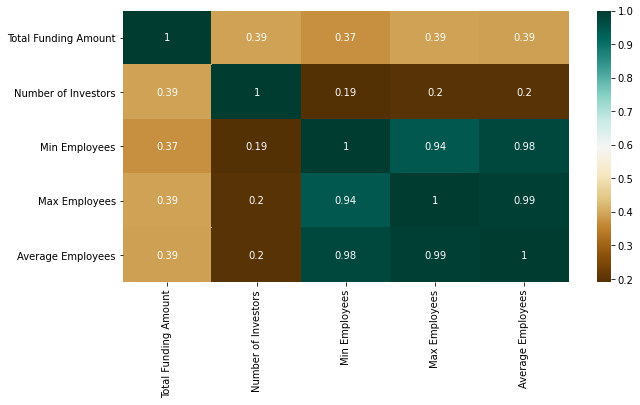

In [62]:
plt.figure(figsize=(10,5))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

Now we see that when we remove some of the heavy hitters from the funding rounds, the correlation between number of investors and funding drops dramatically.

Let's finish up with some text visualization:

In [63]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

def clean_text(text):

  text = str(text).lower()

  text = re.sub('https?://\S+|www\.\S+','',text)
  text = re.sub('<.,*?>+','',text)
  text = re.sub('[%s]' % re.escape(string.punctuation),'',text)

  return text

def preprocess_textdata(text):

  """util function to preprocess text data"""

  text = clean_text(text)
  text = ' '.join(w for w in text.split(' ') if w not in stop_words)
  text = ' '.join(lemmatizer.lemmatize(w) for w in text.split(' '))

  return text

df['Company Description'] = df['Company Description'].apply(preprocess_textdata)

count_vec = CountVectorizer()

count_dtm = count_vec.fit_transform(df['Company Description'])

words = count_vec.get_feature_names()
words_count = count_dtm.sum(axis=0).A1

words_dict = dict(zip(words,words_count))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


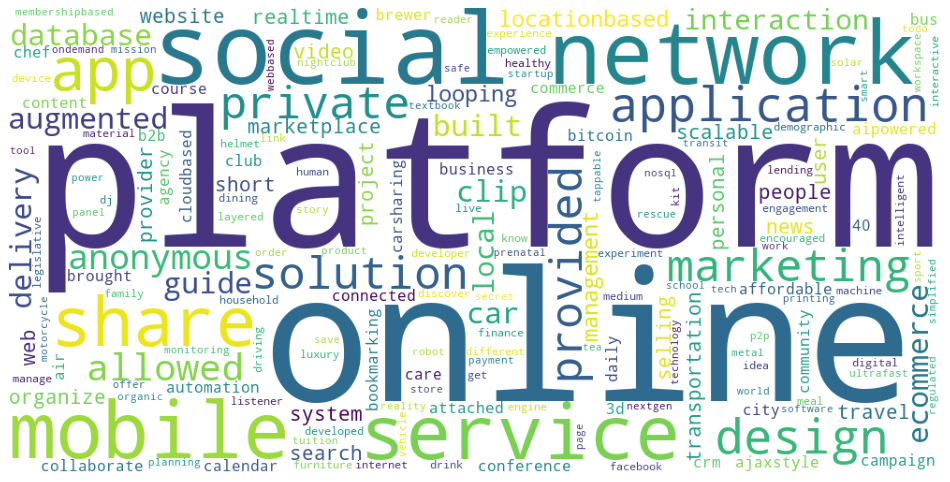

In [64]:
wc = WordCloud(
    background_color = 'white',
    width = 1000,
    height= 500
).generate_from_frequencies(words_dict)

plt.figure(figsize = (13,8))
plt.axis("off")
plt.imshow(wc)
plt.tight_layout(pad=0)
plt.show()